In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import cv2
import os
import pydicom

In [2]:
def printInfo(image, name=""):
    print("--------- {} ---------".format(name))        
    print("{} , {}".format(type(image), image.dtype))
    print(image.shape)
    print("sum / min / max / mean / std")
    print(np.sum(image)) # 4194304
    print(np.min(image)) # -1029
    print(np.max(image)) # -878
    print(np.mean(image)) # -1021.9964039325714
    print(np.std(image)) # 13.835177613499017
    if image.ndim == 2:
        x, y = np.where(image)
        print(np.sum(x))
        print(np.sum(y))
    print()

In [3]:
# input : nifti file path
def find_contours(nii_path):
    
    print(nii_path)
    #exit(0)
    
    # 1) array from input nifti image
    img = nib.load(nii_path).get_fdata()
    #print(type(img))
    #print(img.shape) # (2048, 2048, 1, 1)
    img = img.reshape(img.shape[0], img.shape[1])
    #print(type(img)) # numpy.memmap
    #print(img.shape) # (2048, 2048)
    #printInfo(img, "img - find_contours()")
    #exit(0)
    img = np.array(np.transpose(img)).astype(np.uint8)
    #img = img.astype(np.uint8)
    #printInfo(img, "transpose")
    #exit(0)
    cv2.imwrite(nii_path[:-4]+'.png', img) # 17066541_20150307_fake_0.png
    #exit(0)
    #img_color = cv2.imread(path[:-4]+'.png')
    img_color = cv2.imread(nii_path[:-4]+ '.png')
    #print(type(img_color)) # numpy.ndarray
    #print(img_color.shape) # (2048, 2048, 3)    
    #exit(0)
    
    # 2) generate binary mask image 
    mask = np.where(img > 0,1,0).astype(np.uint8) # 0 or 1 : binary
    #printInfo(mask, "mask - find_contours()")
    #exit(0)
    cv2.imwrite(nii_path[:-4]+'_mask(binary)'+'.png', mask*255) # 17066541_20150307_fake_0_binary.png
    #exit(0)
        
    # 3) find contours from binary mask - using opencv2 findContours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #print(type(contours)) # <class 'tuple'>
    #print(len(contours)) # 2
    #print(type(contours[0])) # <class 'numpy.ndarray'>
    #exit(0)
    
    maskTemp = mask
    #maskTemp = mask * 0 # 
    cv2.drawContours(maskTemp, contours, -1, 255)
    cv2.imwrite(nii_path[:-4]+'_contour'+'.png', maskTemp)
    #printInfo(maskTemp, "maskTemp")
    #exit(0)
    
    
    # 4) sorted contours by length and select top2 
    num = len(contours)
    con = []
    for i in range(num):
        con.append(len(contours[i])) # contours[i] is set of contour pixel
    top2 = sorted(con, reverse=True)[:2]
    #print(top2) # [4639, 4472]
    
    lung_contours = []
    for i in range(num):
        if con[i] in top2:
            lung_contours.append(contours[i])
   
    #print(type(lung_contours)) # <class 'list'>
    #print(lung_contours) # [array(), array()] = [con[0], con[1]]
    #exit(0)

    return img_color, lung_contours
    # output : image, selected contours

In [4]:
# input : contours top2
def center_point(lung_contours):

    # define start/end(=min/max) point at y
    contour_x_st = sorted(lung_contours[0], key=lambda x: x[0][0])[0]
    contour_x_st2 = sorted(lung_contours[1], key=lambda x: x[0][0])[0]
    
    contour_x_ed = sorted(lung_contours[0], key=lambda x: x[0][0])[-1]
    contour_x_ed2 = sorted(lung_contours[1], key=lambda x: x[0][0])[-1]
    
    contour_y_st = sorted(lung_contours[0], key=lambda x: x[0][1])[0]
    contour_y_st2 = sorted(lung_contours[1], key=lambda x: x[0][1])[0]
    
    contour_y_ed = sorted(lung_contours[0], key=lambda x: x[0][1])[-1]
    contour_y_ed2 = sorted(lung_contours[1], key=lambda x: x[0][1])[-1]
    
    center_x = (min(contour_x_st[0][0],contour_x_st2[0][0]) + max(contour_x_ed[0][0],contour_x_ed2[0][0]))//2
    center_y = (min(contour_y_st[0][1],contour_y_st2[0][1]) + max(contour_y_ed[0][1],contour_y_ed2[0][1]))//2
    
    # center x = (min(contour1 min x, contour2 min x) + max(contour1 max x, contour2 max x))//2
    # center y = (min(contour1 min y, contour2 min y) + max(contour1 max y, contour2 max y))//2
    
    #print("{} , {}".format(center_x, center_y)) # 1074 , 914
    #exit(0)
        
    
    return [center_x, center_y]
    # output : center point [x,y]

In [5]:
def center_point_one(lung_contours):
    
    # define start/end(=min/max) point at y
    contour_x_st = sorted(lung_contours[0], key=lambda x: x[0][0])[0]    
    contour_x_ed = sorted(lung_contours[0], key=lambda x: x[0][0])[-1]
    
    contour_y_st = sorted(lung_contours[0], key=lambda x: x[0][1])[0]    
    contour_y_ed = sorted(lung_contours[0], key=lambda x: x[0][1])[-1]
    
    center_x = (contour_x_st[0][0] + contour_x_ed[0][0])//2
    center_y = (contour_y_st[0][1] + contour_y_ed[0][1])//2
    
    # center x = (contour min x + contour max x)//2
    # center y = (contour min y + contour max y)//2
    
  
    return [center_x, center_y]
    # output : center point [x,y]

In [6]:
# input : center point, contours
def full_mask(center, lung_contours):
    
    # 0) load center point
    center_x, center_y = center
    contour1 = []
    contour2 = []
    
    #print("{} , {} - full_mask()".format(center_x, center_y))
    #exit(0)
    
    #print("len(lung_contours): {}".format(len(lung_contours))) # len(lung_contours): 2
    #exit(0)    
    if len(lung_contours) == 2:
        # 1) concatenate if 2 contours
        lung_contours = np.concatenate((lung_contours[0], lung_contours[1]), axis=0)

    #print("lung_contours length: {}".format(len(lung_contours))) # lung_contours length: 9111
    #exit(0)
    

    # 2) split and save 2 contours by center point x value
    for i in lung_contours:
        if i[0][0] > center_x:
            contour1.append(i[0])
        else:
            contour2.append(i[0])
    contour1 = np.array(contour1)
    contour2 = np.array(contour2)
    
    print(len(contour1)) # 4472
    print(len(contour2)) # 4639
    #exit(0)
    
    # define start/end(=min/max) point at y
    contour_y_st = sorted(contour1, key=lambda x: x[1])[0]
    contour_y_st2 = sorted(contour2, key=lambda x: x[1])[0]
    contour_y_ed = sorted(contour1, key=lambda x: x[1])[-1]
    contour_y_ed2 = sorted(contour2, key=lambda x: x[1])[-1]
    
    #print("{} , {} / {} , {}".format(contour_y_st, contour_y_ed, contour_y_st2, contour_y_ed2))
    # [1318  235] , [1619 1593] / [898 247] , [ 594 1571]
    #exit(0)
   
    # 3) fill trapezoid binary mask (airway area) - using opencv FillPoly
    a,b,c = img.shape[0], img.shape[1], img.shape[2]
    print(img.shape) # (2048, 2048, 3)
    #exit(0)
    mask = np.zeros((a, b, c), dtype="uint8")
    print(mask.shape) # (2048, 2048, 3)
    #exit(0)
    
    points = np.array([contour_y_st, contour_y_st2, contour_y_ed2, contour_y_ed])
    cv2.fillPoly(mask, pts=[points], color=(255,255,255)) 
    #printInfo(mask, "polygon fill");
    #exit(0) 

    # 4) fill contour binary mask - using opencv FillPoly
    cv2.fillPoly(mask, pts =[lung_contours], color=(255,255,255))
    #printInfo(mask, "lung_contours fill");
    #exit(0)
    
    return mask
    # output : filled mask

In [7]:
# input : image, filled mask, center point, percentage
def bitwise_mask(img, mask, center_point, percent):
    
    # 1) save contour of filled mask - using opencv findContours
    mask_contour, hierarchy = cv2.findContours(mask[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # 2) for mask contour points do : 
    #        new points : int( (1-percent)*center point + percent*mask contour points )
    mask_points = mask_contour[0]
    print(len(mask_points)) # 4802
    #exit(0)
    
    new_points = []
    for i in range(len(mask_points)):
        x = center_point
        y = mask_points[i][0]
        m = percent
        n = 1-percent
        new_points.append([int((n*a+m*b)) for a,b in zip(x,y)])    
    
    print(len(new_points)) # 4802
    #exit(0)
    
    # 3) filled percent mask - using opencv FillPoly
    a,b,c = img.shape[0], img.shape[1], img.shape[2]
    mask = np.zeros((a,b,c), dtype='uint8')
    
    new_points = np.array(new_points)
    mask = cv2.fillPoly(mask, [new_points], (255,255,255))
    #printInfo(mask[:,:,0], "mask[:,:,0]")
    #exit(0)
    
    # 4) copy image and generate percent masked image - using opencv bitwise_and
    masked = cv2.bitwise_and(img, mask)
    #printInfo(masked[:,:,0], "masked[:,:,0]")
    #exit(0)
    
    return mask, masked
    # output : percent mask, percent masked image (lung or vascular)

In [8]:
# input :  image path and percent masked image, save path and string percentage 
def save_mask(path, mask, save_path, idx):
    
    # 1) load nifti image, header, affine
    nii = nib.load(path)
    header = nii.header
    affine = nii.affine
    
    # 2) generate percent masked image to nifti image (applied header, affine) 
    new_nii = nib.Nifti1Image(np.transpose(mask), affine, header)
    
    # 3) save nifti image at save path
    file_name = os.path.basename(path)[:-4] + '_' + str(idx) + '.nii'
    nib.save(new_nii, save_path +'/'+ file_name)

In [9]:
def get_longest_line(image, image_width, image_height):
    result_ = []

    try:
        # Convert to binary image based on threshold
        binary = np.where(image > -1024, 1, 0)

        # Check if the binary image is all 0 or all 1
        if np.all(binary == 0) or np.all(binary == 1):
            return [[0, 0], [0, 0]]

        # Find the biggest connected region using connected components
        _, labels = cv2.connectedComponents(binary.astype(np.uint8))

        # Find the biggest region (excluding background, which is label 0)
        unique, counts = np.unique(labels, return_counts=True)
        region_label = unique[np.argmax(counts[1:]) + 1]  # excluding the background label 0
        region = (labels == region_label).astype(np.uint8)

        maxCount = 0
        maxY = -1
        counts = []

        # Find the row with the most non-zero values
        for y in range(region.shape[0]):
            count = np.count_nonzero(region[y, :])
            counts.append(count)
            if count > maxCount:
                maxCount = count
                maxY = y

        if maxY == -1:  # Exception case
            return [[0, 0], [0, 0]]

        startX = -1
        endX = -1

        # Find the start and end points in the row with the most non-zero pixels
        for x in range(region.shape[1]):
            if region[maxY, x] == 1:  # 255 for foreground in original code
                if startX == -1:
                    startX = x
                endX = x

        if startX == -1 or endX == -1:  # Exception case
            return [[0, 0], [0, 0]]

        # Return the longest line as the start and end points
        longest_line = [[startX, maxY], [endX, maxY]]
        result_ = longest_line

    except Exception as e:
        # Handle any errors and return a default value
        return [[0, 0], [0, 0]]

    return result_


In [10]:
input_path = "input/dcm/1_Random number_129.dcm"
heart_path = "input/heart/1_Random number_129.DCM_heart.png.nii"
lung_path = "input/lung/1_Random number_129.DCM_lung.png.nii"
output_path = "./output"

In [11]:
data = pydicom.dcmread(input_path)
pixel_spacing = data.PixelSpacing if 'PixelSpacing' in data else None
height = data.Rows
width = data.Columns

In [150]:
lung_contour = []
img, lung_contours = find_contours(lung_path)

D:/20240517_lung_heart_volume_sample/lung/1_Random number_129.DCM_lung.png.nii


In [151]:
for c in lung_contours:
    if len(c) > 1000:   # constant
         lung_contour.append(c)

In [152]:
if len(lung_contour) == 1:
    center = center_point_one(lung_contour)
    masks = full_mask(center, lung_contour)
else:
    center = center_point(lung_contour)
    masks = full_mask(center, lung_contour)

4286
4382
(2048, 2048, 3)
(2048, 2048, 3)


In [153]:
mask, masked = bitwise_mask(img, masks, center, 1.0)
#save_mask(lung_path, mask[:,:,0], output_path, 1.0)

5681
5681
--------- mask[:,:,0] ---------
<class 'numpy.ndarray'> , uint8
(2048, 2048)
sum / min / max / mean / std
353442495
0
255
84.26725745201111
119.94657132148123
1142314294
1345466266

--------- masked[:,:,0] ---------
<class 'numpy.ndarray'> , uint8
(2048, 2048)
sum / min / max / mean / std
78561936
0
255
18.73062515258789
39.48849678195026
893996220
1057418107



In [154]:
mask = mask[:,:,0]
maxCount = 0
maxY = -1
counts = []

for y in range(mask.shape[0]):
    count = cv2.countNonZero(mask[y, :])
    counts.append(count)
    if count > maxCount:
        maxCount = count
        maxY = y

# startX와 endX 찾기
startX = -1
endX = -1

for x in range(mask.shape[1]):
    if mask[maxY, x] == 255:
        if startX == -1:
            startX = x
        endX = x


IDCord = [(startX, maxY), (endX, maxY)]
IDLen = (endX - startX) * pixel_spacing[0] / 10.0
center = startX + ((endX - startX) / 2)

In [155]:
print("IDCord : ", IDCord)
print("IDLen : ", IDLen)
print("center : ", int(center))

IDCord :  [(262, 998), (1635, 998)]
IDLen :  19.0847
center :  948


In [156]:
MHTD = (endX - startX) * pixel_spacing[0]

In [157]:
heart_img = nib.load(heart_path)
heart_data = heart_img.get_fdata()
heart_data = np.squeeze(heart_data)
heart_data = np.transpose(heart_data, (1, 0))
heart_data = np.repeat(heart_data, 4, axis=0)
heart_data = np.repeat(heart_data, 4, axis=1)

In [158]:
left_heart = heart_data[:, :int(center)]
right_heart = heart_data[:, int(center):]

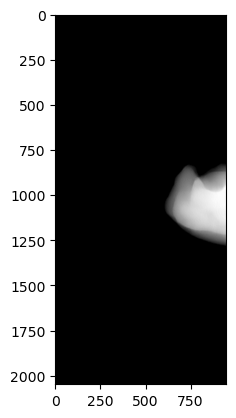

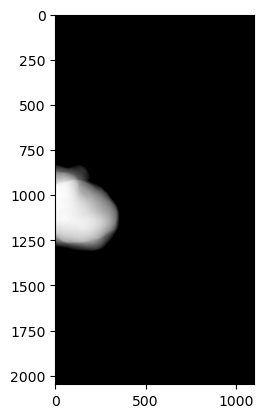

In [159]:
plt.imshow(left_heart, cmap='gray')
plt.show()
plt.imshow(right_heart, cmap='gray')
plt.show()

In [160]:
left_longest_line = get_longest_line(left_heart, center, 2048)
right_longest_line = get_longest_line(right_heart, 2048-center, 2048)
print(left_longest_line)
print(right_longest_line)

[[604, 1048], [947, 1048]]
[[0, 1096], [355, 1096]]


Left Heart Length: 343
Right Heart Length: 355
MHCD: 698
MHTD * spacing: 39.22166773632813
MHCD * spacing: 143.44854296875002
CT Ratio: 3.6573799954937725


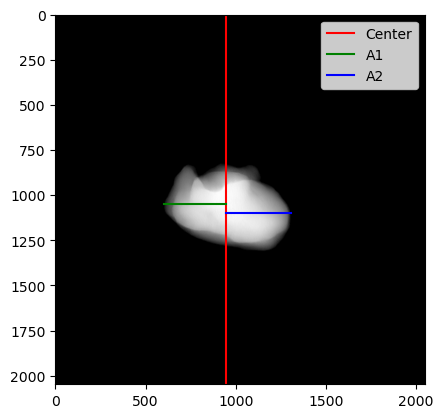

In [161]:
left_length = left_longest_line[1][0] - left_longest_line[0][0]
right_length = right_longest_line[1][0] - right_longest_line[0][0]

print('Left Heart Length:', left_length)
print('Right Heart Length:', right_length)

MHCD = left_length + right_length
print('MHCD:', MHCD)

newSize = 2048
newSpacingX = pixel_spacing[0] * max(width, height) / newSize
newSpacingY = pixel_spacing[1] * max(width, height) / newSize
ct_ratio = (MHCD * newSpacingX) / (MHTD * newSpacingX)
print('MHTD * spacing:', MHTD * newSpacingX)
print('MHCD * spacing:', MHCD * newSpacingX)

print('CT Ratio:', ct_ratio)

plt.imshow(heart_data, cmap='gray')
plt.plot([center, center], [0, 2047], 'r-', label='Center')
plt.plot([left_longest_line[0][0], left_longest_line[1][0]], 
         [left_longest_line[0][1], left_longest_line[1][1]], 
         'g-', label='A1')
plt.plot([right_longest_line[0][0] + center, right_longest_line[1][0] + center],
            [right_longest_line[0][1], right_longest_line[1][1]], 
            'b-', label='A2')

plt.legend()
plt.show()